In [166]:
from __future__ import division
from numpy import sqrt
import scipy.stats as scs


def z_test(ctr_old, ctr_new, nobs_old, nobs_new,
           effect_size=0., two_tailed=True, alpha=.05):
    """Perform z-test to compare two proprtions (e.g., click through rates (ctr)).

        Note: if you set two_tailed=False, z_test assumes H_A is that the effect is
        non-negative, so the p-value is computed based on the weight in the upper tail.

        Arguments:
            ctr_old (float):    baseline proportion (ctr)
            ctr_new (float):    new proportion
            nobs_old (int):     number of observations in baseline sample
            nobs_new (int):     number of observations in new sample
            effect_size (float):    size of effect
            two_tailed (bool):  True to use two-tailed test; False to use one-sided test
                                where alternative hypothesis if that effect_size is non-negative
            alpha (float):      significance level

        Returns:
            z-score, p-value, and whether to reject the null hypothesis
    """
    conversion = (ctr_old * nobs_old + ctr_new * nobs_new) / \
                 (nobs_old + nobs_new)

    se = sqrt(conversion * (1 - conversion) * (1 / nobs_old + 1 / nobs_new))

    z_score = (ctr_new - ctr_old - effect_size) / se

    if two_tailed:
        p_val = (1 - scs.norm.cdf(abs(z_score))) * 2
    else:
        # Because H_A: estimated effect_size > effect_size
        p_val = 1 - scs.norm.cdf(z_score)

    reject_null = p_val < alpha
#     print 'z-score: %s, p-value: %s, reject null: %s' % (z_score, p_val, reject_null)
    return z_score, p_val, reject_null


In [167]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest as ztest

df = pd.read_csv("data/experiment.csv")
df.drop_duplicates
print()

In [168]:
df.head(10)

,user_id,ts,ab,landing_page,converted
0,4040615247,1.356998e+09,treatment,new_page,0
1,4365389205,1.356998e+09,treatment,new_page,0
2,4256174578,1.356998e+09,treatment,new_page,0
3,8122359922,1.356998e+09,control,old_page,0
4,6077269891,1.356998e+09,control,old_page,0
5,4275599187,1.356998e+09,treatment,new_page,0
6,1659259079,1.356998e+09,control,old_page,0
7,1545725891,1.356998e+09,control,old_page,0
8,7347566546,1.356998e+09,treatment,new_page,0
9,8944268730,1.356998e+09,control,old_page,0


In [169]:
ctrl = df[df['ab'] == 'control']['converted'].count()
cc = int(df[df['ab'] == 'control']['converted'].sum()*1.01)
tment = df[df['ab'] == 'treatment']['converted'].count()
tmentc = df[df['ab'] == 'treatment']['converted'].sum()
z_test(cc/ctrl,tmentc/tment,ctrl,tment)

(-0.49863108216718366, 0.6180393041082457, False)

In [170]:
import datetime
df['DT'] = np.array([int(datetime.datetime.fromtimestamp(t).strftime('%H')) - 16 if (int(datetime.datetime.fromtimestamp(t).strftime('%H')) - 16) >= 0 else int(datetime.datetime.fromtimestamp(t).strftime('%H')) + 9 for t in df['ts']])

In [171]:
t, p = [], []

for time in range(24):
    ctrl = df[(df['ab'] == 'control') & (df['DT'] <= time)]['converted'].count()
    cc = df[(df['ab'] == 'control') & (df['DT'] <= time)]['converted'].sum()*1.01
    tment = df[(df['ab'] == 'treatment') & (df['DT'] <= time)]['converted'].count()
    tmentc = df[(df['ab'] == 'treatment') & (df['DT'] <= time)]['converted'].sum()
    _, pv, _ = z_test(cc/ctrl,tmentc/tment,ctrl,tment)
    t.append(time)
    p.append(pv)

In [172]:
pchart = pd.DataFrame([t,p]).T
pchart.columns = ['t','p']

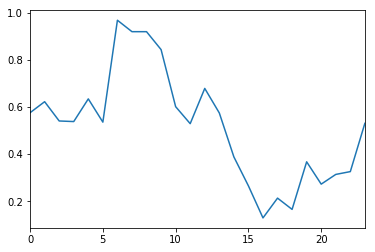

In [173]:
pchart['p'].plot()
plt.show()

In [174]:
cty = pd.read_csv('data/country.csv')
new = df.merge(cty, on = 'user_id', how = 'left')

In [175]:
new.groupby(['country','ab']).sum()['converted']/ new.groupby(['country','ab']).count()['converted']

country  ab       
CA       control      0.101217
         treatment    0.094323
UK       control      0.102032
         treatment    0.096051
US       control      0.098433
         treatment    0.097283
Name: converted, dtype: float64